In [30]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.api import VAR
from pandas_datareader import data as pdr
import datetime
from fredapi import Fred
import numpy as np

In [31]:
import matplotlib.pyplot as plt


In [32]:
api_key = '230970faf44ea208229d77dff9f995f3'
fred = Fred(api_key=api_key)

# Define the series IDs
series_ids = {


    'USGDP': 'GDPC1',
    'ALLUKSHARES': 'SPASTT01GBM661N',
    'USD/GBP': 'DEXUSUK',
    'UKCPI': 'GBRCPIALLMINMEI',
    'UKGDP':'UKNGDP'
}

# Define the observation period
start_date = '1990-01-01'
end_date = '2023-11-30'

# Download the data
data = {}
for series_name, series_id in series_ids.items():
    data[series_name] = fred.get_series(series_id, start_date, end_date, frequency='q')

# Transform the series (log)
for series_name, series_data in data.items():
    data[series_name] = pd.Series(data[series_name])

# Create a DataFrame from the log-transformed data
df = pd.DataFrame(data)
df=np.log(df.dropna())

In [33]:
df

,USGDP,ALLUKSHARES,USD/GBP,UKCPI,UKGDP
1990-01-01,9.215068,3.553733,0.504103,3.966511,12.001849
1990-04-01,9.218691,3.537035,0.515813,4.004906,12.024065
1990-07-01,9.219357,3.513085,0.622832,4.019980,12.043954
1990-10-01,9.210211,3.468051,0.664696,4.040709,12.049150
1991-01-01,9.205520,3.542305,0.644377,4.047136,12.062156
...,...,...,...,...,...
2022-07-01,9.992008,4.705899,0.162714,4.802107,13.354508
2022-10-01,9.998342,4.702816,0.161609,4.826712,13.376526
2023-01-01,10.003891,4.768148,0.194991,4.835223,13.397460
2023-04-01,10.008989,4.759615,0.224662,4.859295,13.422629


In [34]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

def decompose_data(data, freq='q'):
    decomposed_data = {}
    dec_trend = pd.DataFrame()

    for column in data.columns:
        # Ensure the data index is a DatetimeIndex
        if not isinstance(data.index, pd.DatetimeIndex):
            raise ValueError("Data index must be a DatetimeIndex.")

        # Drop NA values and set the frequency
        series = data[column].dropna()

        # Decompose the time series
        decomposition = sm.tsa.seasonal_decompose(series, model='additive', period=4)  # Adjust the period based on the data frequency
        dec_trend[column] = decomposition.trend

        # Store the decomposition components in a dictionary
        decomposed_data[column] = {
            'trend': decomposition.trend,
            'seasonal': decomposition.seasonal,
            'residual': decomposition.resid
        }

        # Visualize the decomposed components
        plt.figure(figsize=(14, 6))

        plt.subplot(221)
        plt.plot(decomposed_data[column]['trend'])
        plt.title(f'Trend of {column}')

        plt.subplot(222)
        plt.plot(decomposed_data[column]['seasonal'])
        plt.title(f'Seasonal of {column}')

        plt.subplot(223)
        plt.plot(decomposed_data[column]['residual'])
        plt.title(f'Residual of {column}')

        plt.subplot(224)
        plt.plot(data[column])
        plt.title(f'Original {column}')

        plt.tight_layout()
        plt.show()

    return dec_trend


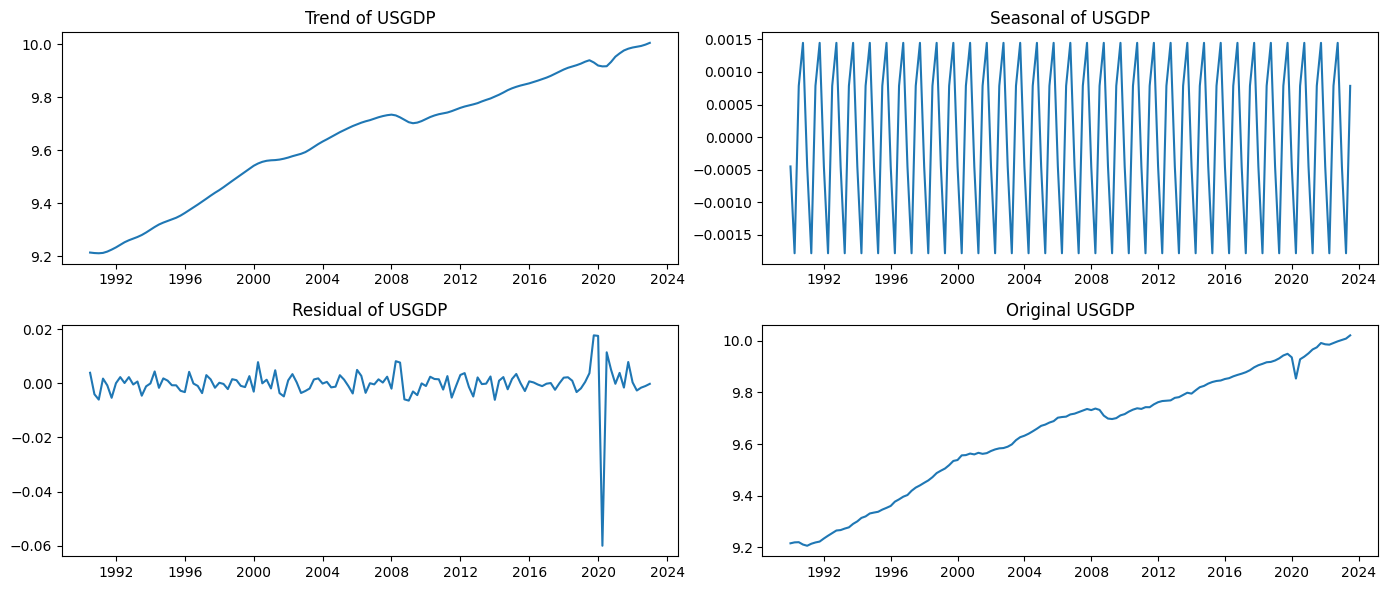

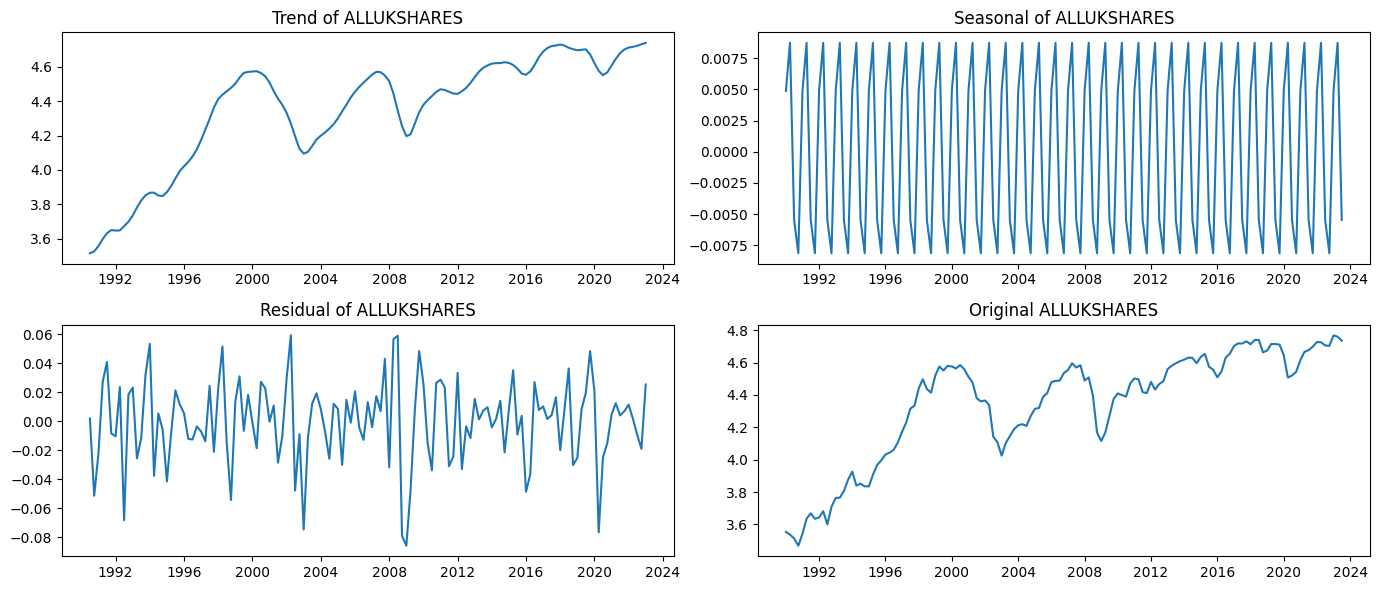

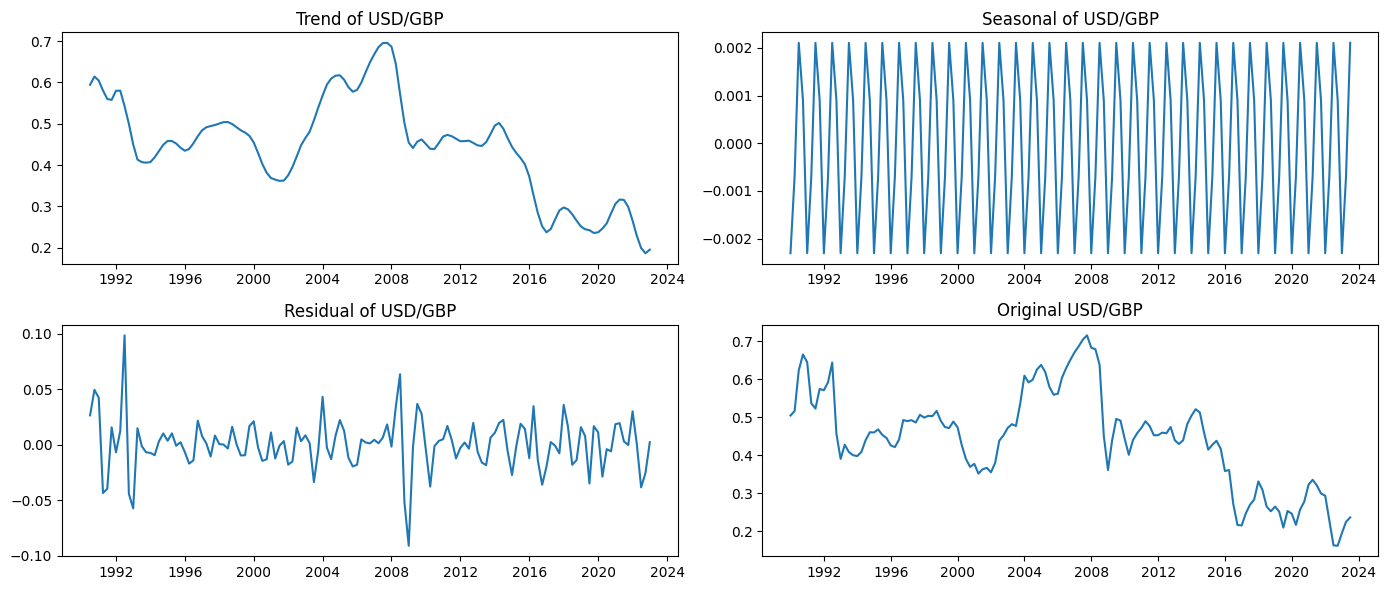

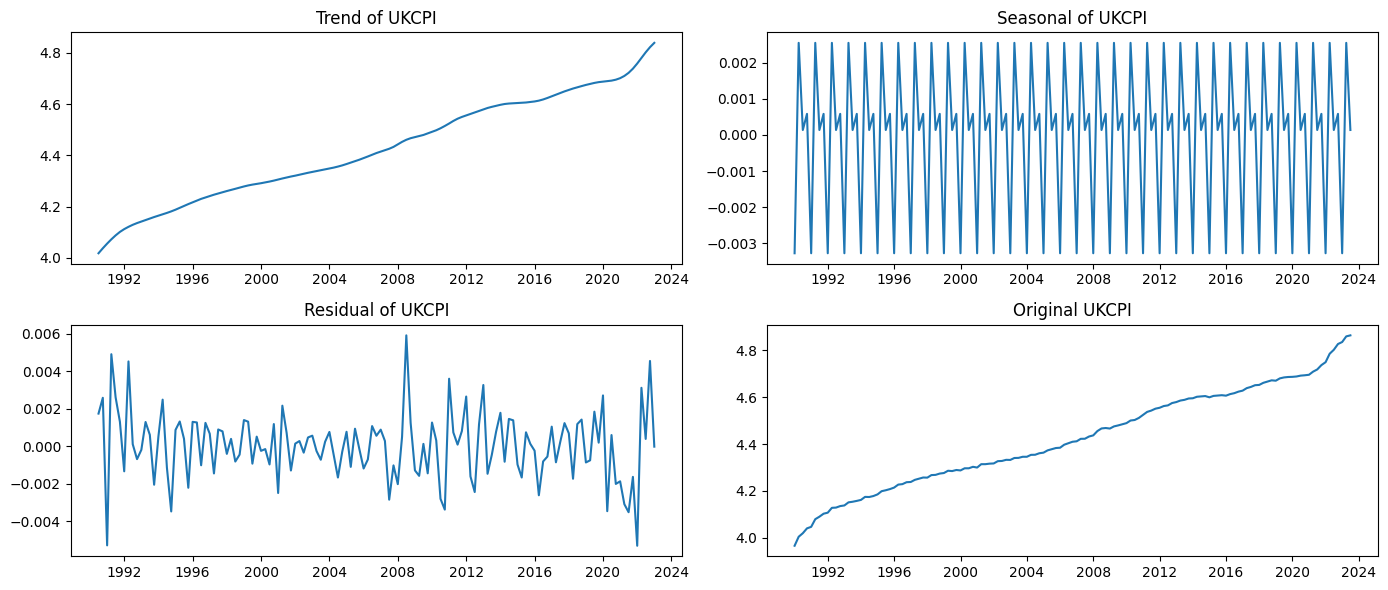

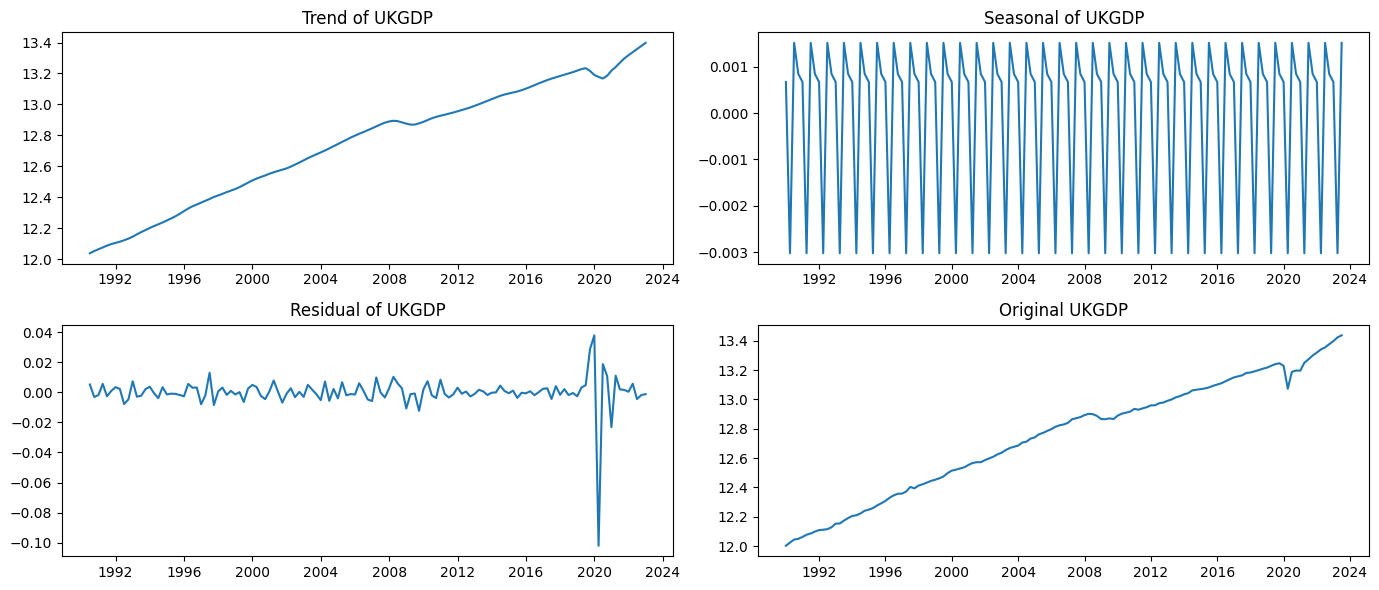

,USGDP,ALLUKSHARES,USD/GBP,UKCPI,UKGDP
1990-01-01,NaN,NaN,NaN,NaN,NaN
1990-04-01,NaN,NaN,NaN,NaN,NaN
1990-07-01,9.214638,3.516548,0.594395,4.018105,12.037293
1990-10-01,9.212769,3.527431,0.614478,4.037544,12.051476
1991-01-01,9.211965,3.559148,0.604475,4.055714,12.063313
...,...,...,...,...,...
2022-07-01,9.992792,4.720405,0.199166,4.801583,13.357528
2022-10-01,9.997864,4.729839,0.186442,4.821581,13.377541
2023-01-01,10.004501,4.737784,0.195167,4.838531,13.398046
2023-04-01,NaN,NaN,NaN,NaN,NaN


In [35]:
decompose_data(df)

# Trend and drift check

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'df' is the DataFrame with each column as a time series.

# Define a function to regress each series on its decomposed trend component
def regress_on_decomposed_trend(df):
    results = {}
    for column in df.columns:
        # Decompose the series
        decomposition = seasonal_decompose(df[column], model='additive', period=1)  # Assuming no seasonality
        trend = decomposition.trend.dropna()  # Extract the trend and drop NA values
        
        # Prepare the data for regression by aligning the trend and the original series
        aligned_series = df[column][trend.index[0]:trend.index[-1]]
        
        # Add a constant for regression (intercept term)
        X = sm.add_constant(trend)
        
        # Fit the regression model
        model = sm.OLS(aligned_series, X).fit()
        
        # Save the results
        results[column] = model
        
    return results

# Example usage:
# Assuming 'df' is your DataFrame with time series data in each column
trend_regression_results = regress_on_decomposed_trend(df)

# To print the summary for each regression model
for series_name, model in trend_regression_results.items():
    print(f"Regression Summary for {series_name}:")
    print(model.summary())
    print("\n\n")


Regression Summary for USGDP:
                            OLS Regression Results                            
Dep. Variable:                  USGDP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.725e+27
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        09:01:37   Log-Likelihood:                 3999.3
No. Observations:                 135   AIC:                            -7995.
Df Residuals:                     133   BIC:                            -7989.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.105e-15 

# Seasonality Check

In [37]:
df=df.reset_index()
df

,index,USGDP,ALLUKSHARES,USD/GBP,UKCPI,UKGDP
0,1990-01-01,9.215068,3.553733,0.504103,3.966511,12.001849
1,1990-04-01,9.218691,3.537035,0.515813,4.004906,12.024065
2,1990-07-01,9.219357,3.513085,0.622832,4.019980,12.043954
3,1990-10-01,9.210211,3.468051,0.664696,4.040709,12.049150
4,1991-01-01,9.205520,3.542305,0.644377,4.047136,12.062156
...,...,...,...,...,...,...
130,2022-07-01,9.992008,4.705899,0.162714,4.802107,13.354508
131,2022-10-01,9.998342,4.702816,0.161609,4.826712,13.376526
132,2023-01-01,10.003891,4.768148,0.194991,4.835223,13.397460
133,2023-04-01,10.008989,4.759615,0.224662,4.859295,13.422629


In [38]:
df.index=pd.to_datetime(df.index,format='%Y-%m-%d')

In [39]:
import pandas as pd
from scipy.stats import kruskal

# Assuming 'df' is the DataFrame with each column as a time series.
# Also assuming there is a 'date' column or index to determine the season for each observation.

# Define a function to apply Kruskal-Wallis test for seasonal variations
def test_seasonal_variation(df, date_column_or_index):
    results = {}
    for column in df.columns:
        # Create a new column to identify the season for each row
        seasons = df[date_column_or_index].apply(lambda x: (x.month%12 + 3)//3)  # 1:Winter, 2:Spring, 3:Summer, 4:Autumn
        
        # Group the data by season
        groups = [df.loc[seasons == i, column].dropna() for i in range(1, 5)]
        
        # Apply the Kruskal-Wallis test to these groups
        statistic, p_value = kruskal(*groups)
        
        # Save the results
        results[column] = {
            'H-statistic': statistic,
            'p-value': p_value
        }
        
    return results

# Example usage:
# Assuming 'df' has a 'date' column or index
seasonal_variation_results = test_seasonal_variation(df, 'index')

# To print the results for each time series
# for series_name, result in seasonal_variation_results.items():
#     print(f"Seasonal Variation Test Results for {series_name}:")
#     print(f"H-statistic: {result['H-statistic']}, p-value: {result['p-value']}")
#     print("\n")


In [40]:
seasonal_variation_results

{'index': {'H-statistic': 0.04444444444442297, 'p-value': 0.9975409815092212},
 'USGDP': {'H-statistic': 0.058766441811371806, 'p-value': 0.9962772044596395},
 'ALLUKSHARES': {'H-statistic': 0.11018372886883299,
  'p-value': 0.9905879415400393},
 'USD/GBP': {'H-statistic': 0.20319477979828277,
  'p-value': 0.9770719106776553},
 'UKCPI': {'H-statistic': 0.06552699602691268, 'p-value': 0.9956255063498208},
 'UKGDP': {'H-statistic': 0.060712662961748265, 'p-value': 0.9960930188912787}}

# ACF PCF PLOTS

In [41]:
df=df.set_index('index')

In [42]:
firs_diff_detrended_df

,level_0,index,USGDP,ALLUKSHARES,USD/GBP,UKCPI,UKGDP
1,1.0,90 days,-0.002308,-0.024047,0.013605,0.033005,0.012294
2,1.0,91 days,-0.005265,-0.031298,0.108914,0.009685,0.009967
3,1.0,92 days,-0.015077,-0.052383,0.043759,0.015340,-0.004726
4,1.0,92 days,-0.010621,0.066905,-0.018424,0.001038,0.003084
5,1.0,90 days,0.001836,0.085877,-0.106281,0.027269,0.005144
...,...,...,...,...,...,...,...
130,1.0,91 days,0.000634,-0.026823,-0.063642,0.011450,0.003873
131,1.0,92 days,0.000403,-0.010432,0.000789,0.019216,0.012096
132,1.0,92 days,-0.000382,0.057983,0.035277,0.003121,0.011012
133,1.0,90 days,-0.000833,-0.015882,0.031566,0.018683,0.015247


C:\Users\zgcha\AppData\Roaming\Python\Python39\site-packages\statsmodels\regression\linear_model.py:1489: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


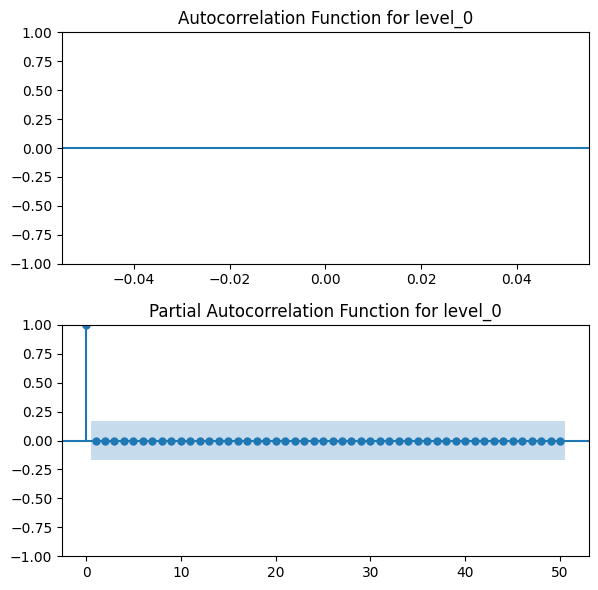

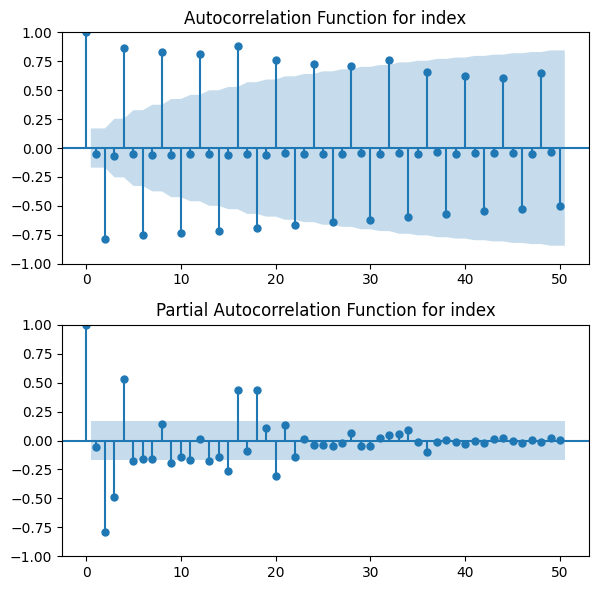

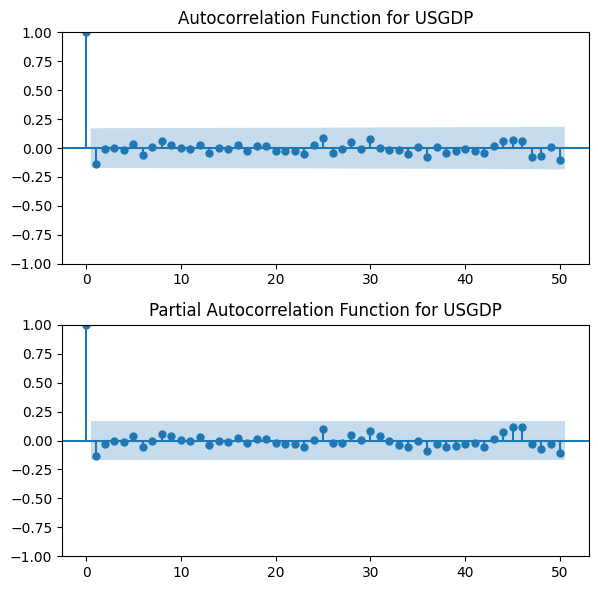

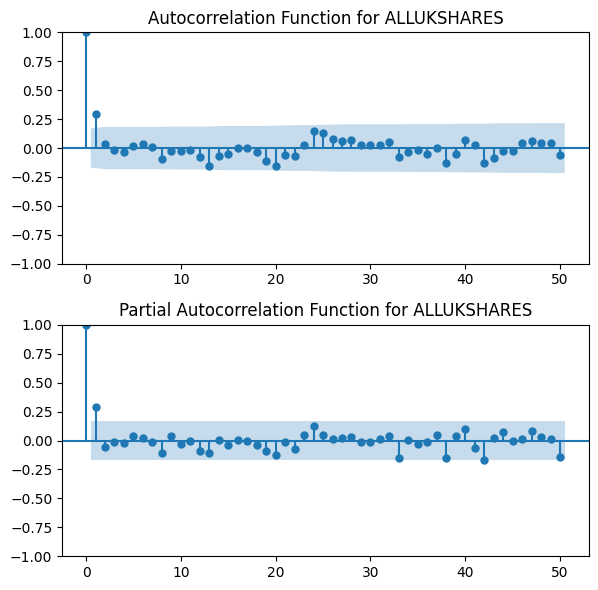

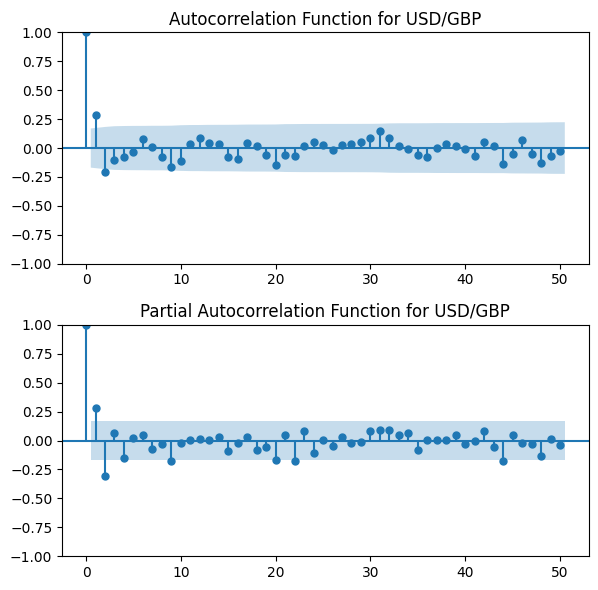

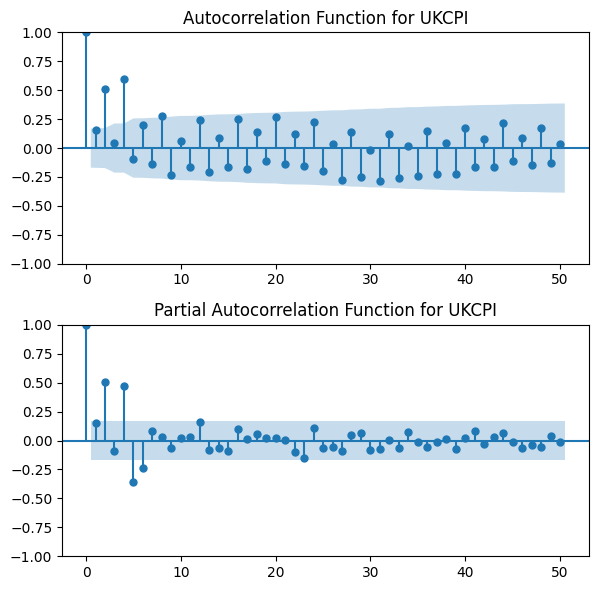

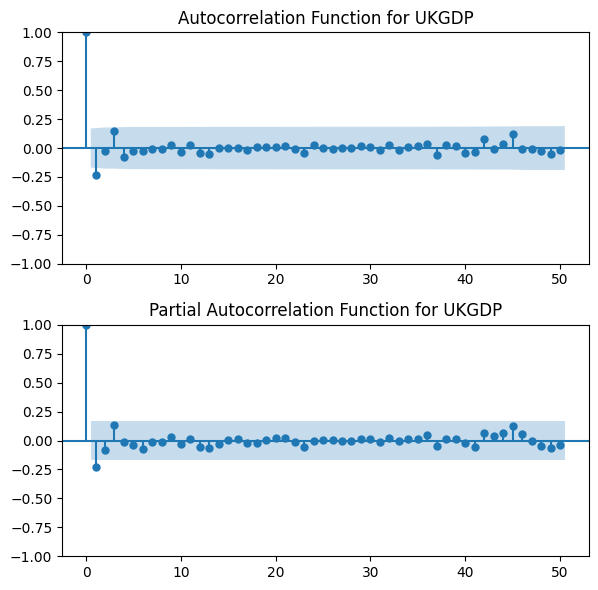

{'USGDP': (1, 1), 'ALLUKSHARES': (1, 1), 'USD/GBP': (2, 2), 'UKCPI': (1, 1)}

In [43]:
###### import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Suppose 'firs_diff_detrended_df' is your pre-processed DataFrame
# with the first differences of the detrended series.

# Define a function to plot ACF and PACF for each series in the dataframe
def plot_acf_pacf(df, lags=50):
    for column in df.columns:
        fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 6))

        # Plot ACF
        plot_acf(df[column].dropna(), lags=lags, ax=ax1, title=f'Autocorrelation Function for {column}')

        # Plot PACF
        plot_pacf(df[column].dropna(), lags=lags, ax=ax2, title=f'Partial Autocorrelation Function for {column}')

        plt.tight_layout()
        plt.show()

# Assuming 'firs_diff_detrended_df' is your DataFrame with time series data in each column
# plot_acf_pacf(firs_diff_detrended_df)


# Example usage:
# Assuming 'df' is your DataFrame with time series data in each column
plot_acf_pacf(firs_diff_detrended_df)

# Note: Uncomment the above line to run the function for your DataFrame.
{"USGDP":(1,1),'ALLUKSHARES':(1,1),'USD/GBP':(2,2),'UKCPI':(1,1)}

# Detrending the series AND check for seasonality

In [44]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Define a function to detrend each series in the dataframe
def detrend_series(df):
    detrended_data = pd.DataFrame().reindex_like(df)
    for column in df.columns:
        # Fit a linear model to the data
        X = sm.add_constant(np.arange(len(df[column])))
        model = sm.OLS(df[column], X).fit()
        
        # Subtract the trend component from the original series
        detrended_data[column] = df[column] - model.predict(X)
    
    return detrended_data

# Example usage:
# Assuming 'df' is your DataFrame with time series data in each column
detrended_df = detrend_series(df)

# Note: Uncomment the above line to run the function and detrend your DataFrame.


In [45]:
detrended_df=detrended_df.reset_index()

In [46]:
test_seasonal_variation(detrended_df, 'index')

{'index': {'H-statistic': 0.04444444444442297, 'p-value': 0.9975409815092212},
 'USGDP': {'H-statistic': 0.2782973914461877, 'p-value': 0.9640571037632777},
 'ALLUKSHARES': {'H-statistic': 0.14943786189456887,
  'p-value': 0.9853065738466987},
 'USD/GBP': {'H-statistic': 0.17877972341636905, 'p-value': 0.980940014140595},
 'UKCPI': {'H-statistic': 2.10878741276656, 'p-value': 0.5501370566086003},
 'UKGDP': {'H-statistic': 0.08941724045530464, 'p-value': 0.9930764237571825}}

In [47]:
detrended_df=detrended_df.set_index('index')

<Figure size 2000x1600 with 0 Axes>

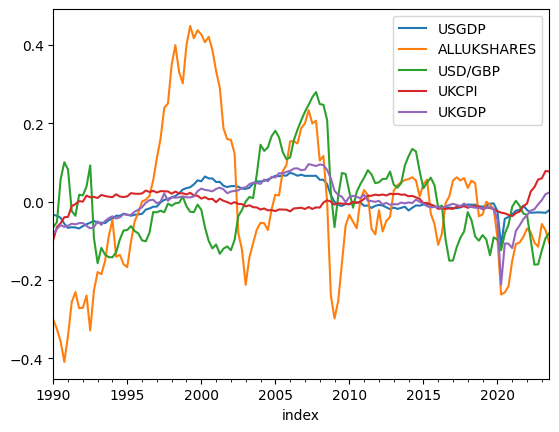

In [48]:
plt.figure(figsize=(20,16))
detrended_df.plot()
plt.show()

# check for a stochastic trend on the detrended series


In [49]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from stargazer.stargazer import Stargazer

def determine_differencing_order_for_all(data):
    results = []
    for column in data.columns:
        series = data[column].dropna()
        d = 0
        adf_result = None

        while True:
            adf_result = adfuller(series)
            if adf_result[1] <= 0.05:
                break
            else:
                d += 1
                series = series.diff().dropna()

        results.append({
            'Column': column,
            'Differencing Order': d,
            'ADF Statistic': adf_result[0],
            'P-Value': adf_result[1],
            'Critical Values': adf_result[4]
        })

    return pd.DataFrame(results)

# Assuming `data` is your DataFrame
result_df = determine_differencing_order_for_all(detrended_df)
result_df


,Column,Differencing Order,ADF Statistic,P-Value,Critical Values
0,USGDP,1,-13.111178,1.633645e-24,"{'1%': -3.480500383888377, '5%': -2.8835279559..."
1,ALLUKSHARES,1,-8.477712,1.420511e-13,"{'1%': -3.480500383888377, '5%': -2.8835279559..."
2,USD/GBP,1,-9.706711,1.037238e-16,"{'1%': -3.4808880719210005, '5%': -2.883696619..."
3,UKCPI,1,-2.923673,4.266357e-02,"{'1%': -3.4851223522012855, '5%': -2.885537500..."
4,UKGDP,1,-14.466279,6.718777e-27,"{'1%': -3.480500383888377, '5%': -2.8835279559..."


In [50]:
detrended_df=detrended_df.set_index('index')

KeyError: "None of ['index'] are in the columns"

In [52]:
detrended_df

,USGDP,ALLUKSHARES,USD/GBP,UKCPI,UKGDP
index,,,,,
1990-01-01,-0.033509,-0.301205,-0.065550,-0.097633,-0.081825
1990-04-01,-0.035817,-0.325252,-0.051945,-0.064628,-0.069531
1990-07-01,-0.041082,-0.356550,0.056968,-0.054943,-0.059564
1990-10-01,-0.056159,-0.408934,0.100727,-0.039603,-0.064290
1991-01-01,-0.066780,-0.342028,0.082303,-0.038566,-0.061206
...,...,...,...,...,...
2022-07-01,-0.027581,-0.104395,-0.160617,0.037326,-0.019038
2022-10-01,-0.027178,-0.114826,-0.159827,0.056543,-0.006942
2023-01-01,-0.027560,-0.056843,-0.124550,0.059664,0.004070


firs_diff_detrended_df= detrended_df.diff().dropna()


In [53]:
firs_diff_detrended_df= detrended_df.diff().dropna()


<Axes: xlabel='index'>

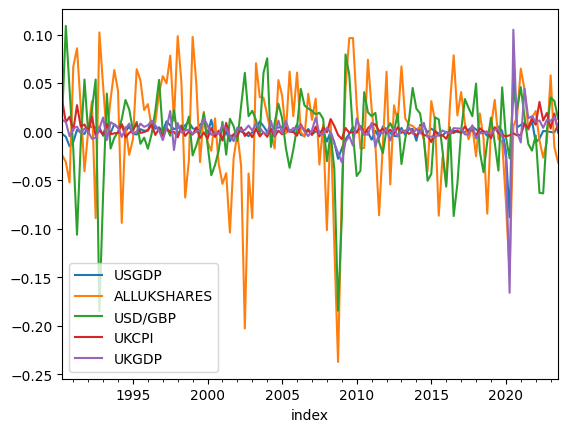

In [54]:
firs_diff_detrended_df.plot()

In [65]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

Best_orders = {"USGDP":(1,40),'ALLUKSHARES':(1,10),'USD/GBP':(2,10),'UKCPI':(1,10)}

def find_best_arma_and_forecast(df):
    for column in df.columns:
        series = df[column].dropna()

        # Check if the column is in the Best_orders dictionary
        if column in Best_orders:
            # Use the specified best order
            best_order = Best_orders[column]
        else:
            print(f"No specified best order for {column}. Skipping.")
            continue

        # Fit ARMA model using the best order
        model = ARIMA(series, order=(best_order[0], 0, best_order[1]))
        model_fit = model.fit()

        # Forecast the next 5 periods
        forecast = model_fit.forecast(steps=10)

        # Generate future dates for the forecast based on the last date in the index
        last_date = series.index[-2]
        future_dates = pd.date_range(start=last_date, periods=10, closed='right')  # Assuming a daily frequency

        # Create a forecast series with future dates as the index
        forecast_series = pd.Series(forecast, index=future_dates)

        # Plot the forecast
        plt.figure(figsize=(10, 6))
        plt.plot(series, label='Original')
        plt.plot(forecast, label='Forecast')
        plt.title(f"ARMA Forecast for {column}")
        plt.legend()
        plt.show()
        print(forecast)


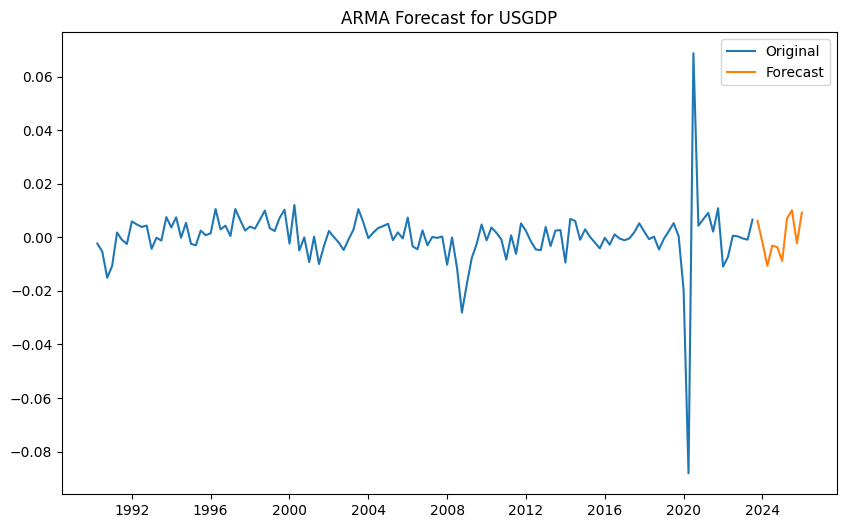

2023-10-01    0.006214
2024-01-01   -0.001828
2024-04-01   -0.010599
2024-07-01   -0.003071
2024-10-01   -0.003600
2025-01-01   -0.008780
2025-04-01    0.007092
2025-07-01    0.010129
2025-10-01   -0.002209
2026-01-01    0.009283
Freq: QS-OCT, Name: predicted_mean, dtype: float64


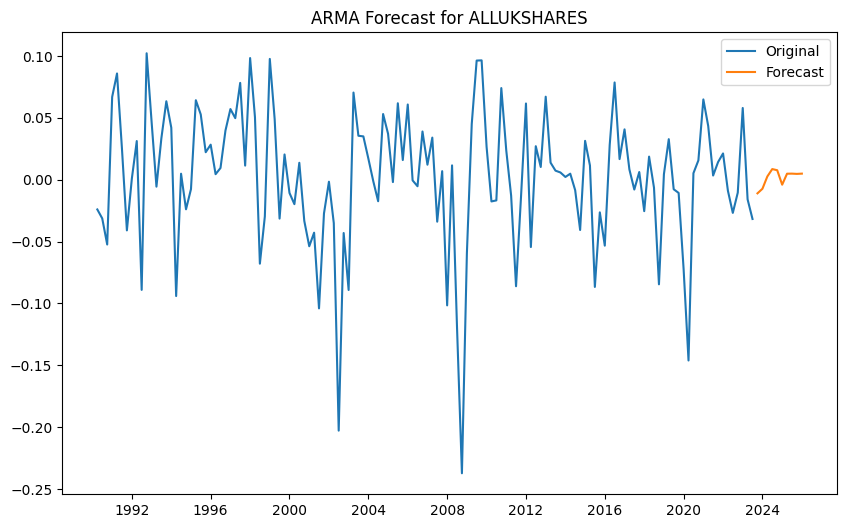

2023-10-01   -0.011025
2024-01-01   -0.007327
2024-04-01    0.002627
2024-07-01    0.008593
2024-10-01    0.007663
2025-01-01   -0.004024
2025-04-01    0.004856
2025-07-01    0.004912
2025-10-01    0.004700
2026-01-01    0.004915
Freq: QS-OCT, Name: predicted_mean, dtype: float64


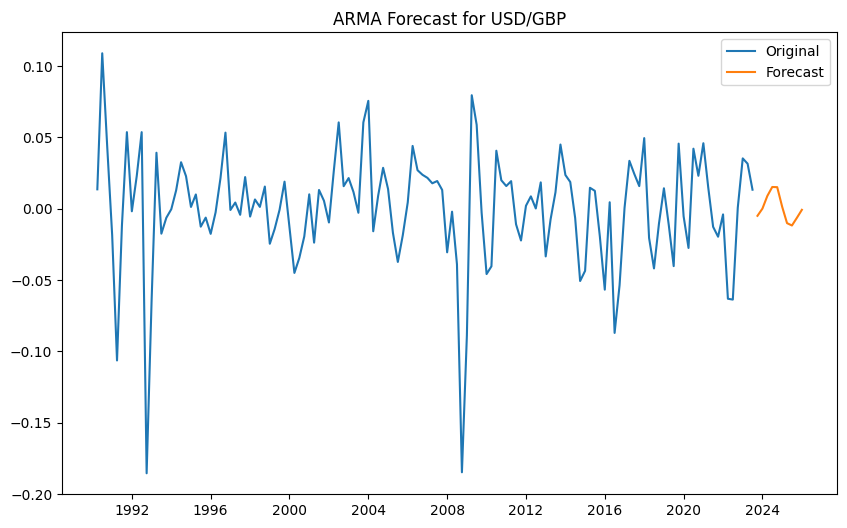

2023-10-01   -0.004958
2024-01-01    0.000095
2024-04-01    0.008977
2024-07-01    0.015237
2024-10-01    0.015123
2025-01-01    0.001375
2025-04-01   -0.010084
2025-07-01   -0.011730
2025-10-01   -0.006343
2026-01-01   -0.000754
Freq: QS-OCT, Name: predicted_mean, dtype: float64


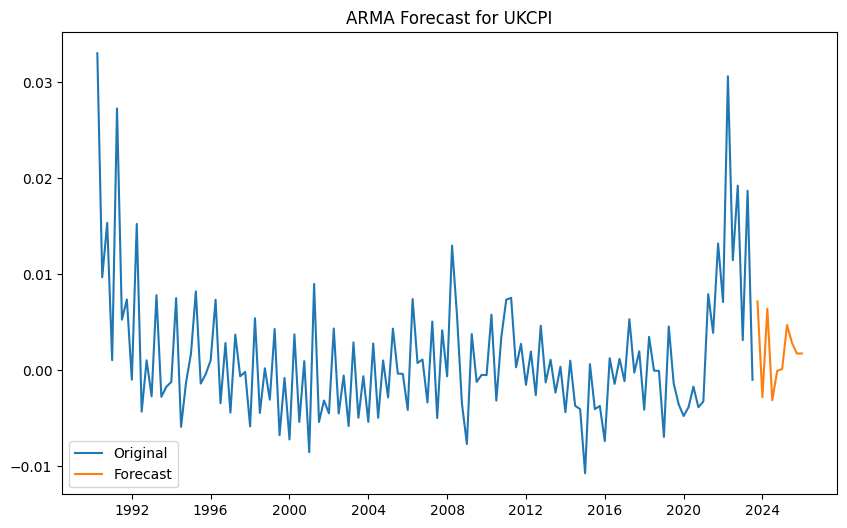

2023-10-01    0.007163
2024-01-01   -0.002807
2024-04-01    0.006413
2024-07-01   -0.003136
2024-10-01   -0.000066
2025-01-01    0.000122
2025-04-01    0.004708
2025-07-01    0.002858
2025-10-01    0.001726
2026-01-01    0.001741
Freq: QS-OCT, Name: predicted_mean, dtype: float64
No specified best order for UKGDP. Skipping.


In [66]:
find_best_arma_and_forecast(firs_diff_detrended_df)


### FE1-Empirical analysis 2
Use 3 (or more) series (at least one series of prices for (stock or bond) indexes +
at least one macroeconomic series), each, with a unit root
• Check the presence of unit root for each series (as in the first empirical
analysis, with the joint analysis of deterministic and stochastic trends)
• Estimate a canonical VAR model :
o without differencing the series of the system
▪ Identify the order of the VAR model
▪ Estimate the different equations
o with first differences of the I(1) components
▪ Identify the order of the VAR model
▪ Estimate the different equations

In [50]:
firs_diff_detrended_df

,USGDP,ALLUKSHARES,USD/GBP,UKCPI
index,,,,
1990-04-01,-0.002308,-0.024047,0.013605,0.033005
1990-07-01,-0.005265,-0.031298,0.108914,0.009685
1990-10-01,-0.015077,-0.052383,0.043759,0.015340
1991-01-01,-0.010621,0.066905,-0.018424,0.001038
1991-04-01,0.001836,0.085877,-0.106281,0.027269
...,...,...,...,...
2022-07-01,0.000634,-0.026823,-0.063642,0.011450
2022-10-01,0.000403,-0.010432,0.000789,0.019216
2023-01-01,-0.000382,0.057983,0.035277,0.003121


In [52]:
determine_differencing_order_for_all(df)

,Column,Differencing Order,ADF Statistic,P-Value,Critical Values
0,USGDP,1,-13.111178,1.633645e-24,"{'1%': -3.480500383888377, '5%': -2.8835279559..."
1,ALLUKSHARES,1,-8.477712,1.420511e-13,"{'1%': -3.480500383888377, '5%': -2.8835279559..."
2,USD/GBP,1,-9.706711,1.037238e-16,"{'1%': -3.4808880719210005, '5%': -2.883696619..."
3,UKCPI,1,-2.923673,4.266357e-02,"{'1%': -3.4851223522012855, '5%': -2.885537500..."


# VAR
## Johansen co-integration 


In [69]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def full_johansen_test_output(df, det_order=0):
    """
    Perform the Johansen Cointegration Test and output full results
    :param df: DataFrame with time series data
    :param det_order: Deterministic order (-1, 0, 1)
    :return: Full results of the cointegration test
    """
    coint_test = coint_johansen(df, det_order=det_order, k_ar_diff=1)
    results = {
        'Eigenvalues': coint_test.eig,
        'Eigenvectors': coint_test.evec,
        'Order of Eigenvalues': coint_test.ind,
        'Trace Statistic': coint_test.lr1,
        'Maximum Eigenvalue Statistic': coint_test.lr2,
        'Critical Values of Trace Statistic (90%, 95%, 99%)': coint_test.cvt,
        'Critical Values of Max Eigenvalue Statistic (90%, 95%, 99%)': coint_test.cvm,
        'Column Names': df.columns.tolist(),  # Adding column names
        'Test Method': coint_test.meth
    }
    return results

# Assuming 'detrended_df' is your DataFrame and contains time series columns
# Apply the test
full_results = full_johansen_test_output(detrended_df)

# Output the results
for key, value in full_results.items():
    print(f"{key}:\n{value}\n")


Eigenvalues:
[0.19305306 0.13702023 0.10679787 0.05784512 0.02090414]

Eigenvectors:
[[ 10.36366203   8.66999558 -84.98371672  15.39769689  23.16820961]
 [  2.10296492   5.01343791   6.67645288   1.0289906   -4.54307199]
 [ 11.72524193  -0.64133753  -1.89464134  -5.50882275  -1.84452895]
 [ 31.8870686   -2.36043536 -30.72406941   9.04339606  55.05712354]
 [-33.7804455   -3.71331138  50.73364662 -22.45381219  -0.65604326]]

Order of Eigenvalues:
[0 1 2 3 4]

Trace Statistic:
[73.88350724 45.35535751 25.75594231 10.73460721  2.80972148]

Maximum Eigenvalue Statistic:
[28.52814973 19.5994152  15.0213351   7.92488574  2.80972148]

Critical Values of Trace Statistic (90%, 95%, 99%):
[[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Critical Values of Max Eigenvalue Statistic (90%, 95%, 99%):
[[31.2379 33.8777 39.3693]
 [25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.70

In [70]:
full_results = full_johansen_test_output(firs_diff_detrended_df)

# Output the results
for key, value in full_results.items():
    print(f"{key}:\n{value}\n")

Eigenvalues:
[0.48464418 0.43516948 0.41067342 0.27528238 0.14415063]

Eigenvectors:
[[ 1.01235645e+01 -8.06252242e+01 -2.52999880e+02 -8.53538295e+01
  -5.88240352e+01]
 [ 4.19106977e+00  1.31381171e+01  1.36148911e+01 -1.82073947e+01
  -3.69898981e-01]
 [ 1.79686052e+01 -2.06106710e+01  1.54413339e+01  2.14717832e-01
  -4.65199173e+00]
 [ 7.68280903e+01 -5.44495189e+01 -1.45140489e+02 -5.49290266e+01
   1.62990914e+02]
 [-8.51210510e+01 -7.45201092e+00  1.38240078e+02  4.21974432e+01
   3.27104032e+01]]

Order of Eigenvalues:
[0 1 2 3 4]

Trace Statistic:
[295.75076945 208.24827164 132.84597059  63.0476983   20.54723742]

Maximum Eigenvalue Statistic:
[87.50249781 75.40230104 69.7982723  42.50046088 20.54723742]

Critical Values of Trace Statistic (90%, 95%, 99%):
[[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Critical Values of Max Eigenvalue Statistic (90%, 95%, 99%):
[[31.2379 33.8777 39.3693

In [79]:
import statsmodels.tsa.stattools as ts

results = {}
for column in detrended_df.columns:
    if column != 'USGDP':
        # Running the Engle-Granger cointegration test
        test_result = ts.coint(detrended_df['USGDP'], detrended_df[column])
        # Extracting the test statistic and p-value
        test_stat, p_value, _ = test_result
        results[column] = (test_stat, p_value)

# Output the results
for column, (test_stat, p_value) in results.items():
    print(f"Cointegration test between USGDP and {column}:")
    print(f"ADF Statistic: {test_stat}, P-value: {p_value}\n")


Cointegration test between USGDP and ALLUKSHARES:
ADF Statistic: -1.8844317252961302, P-value: 0.587881584257195

Cointegration test between USGDP and USD/GBP:
ADF Statistic: -2.12990305200078, P-value: 0.4607494044306315

Cointegration test between USGDP and UKCPI:
ADF Statistic: -1.7301006175264575, P-value: 0.6630119010503868

Cointegration test between USGDP and UKGDP:
ADF Statistic: -2.4621982833584637, P-value: 0.29599024865872814



Co-integration check for the firest difference detrended series


In [77]:
import statsmodels.tsa.stattools as ts

results = {}
for column in firs_diff_detrended_df.columns:
    if column != 'USGDP':
        # Running the Engle-Granger cointegration test
        test_result = ts.coint(firs_diff_detrended_df['USGDP'], firs_diff_detrended_df[column])
        # Extracting the test statistic and p-value
        test_stat, p_value, _ = test_result
        results[column] = (test_stat, p_value)

# Output the results
for column, (test_stat, p_value) in results.items():
    print(f"Cointegration test between USGDP and {column}:")
    print(f"ADF Statistic: {test_stat}, P-value: {p_value}\n")


Cointegration test between USGDP and ALLUKSHARES:
ADF Statistic: -9.802606902167609, P-value: 7.82962674625902e-16

Cointegration test between USGDP and USD/GBP:
ADF Statistic: -13.40219759721152, P-value: 4.534767891167845e-24

Cointegration test between USGDP and UKCPI:
ADF Statistic: -13.128076870614208, P-value: 1.5541356347679204e-23

Cointegration test between USGDP and UKGDP:
ADF Statistic: -6.669261450009894, P-value: 5.137074814760076e-08



Co-integration check for the detrended series


In [95]:
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

# Assuming 'df' is your DataFrame and contains 'USGDP' and other columns

def engle_granger_cointegration_test(y, x):
    """
    Perform Engle-Granger two-step cointegration test
    :param y: dependent variable
    :param x: independent variable
    :return: ADF test statistic and p-value for the residuals
    """
    # Step 1: Regress on x
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    residuals = model.resid

    # Step 2: Test for unit root in the residuals
    adf_test = ts.adfuller(residuals)
    return adf_test[0], adf_test[1]  # Test statistic and p-value

# Testing cointegration between 'USGDP' and each other column
results = {}
for column in detrended_df.columns:
    if column != 'USGDP':
        test_stat, p_value = engle_granger_cointegration_test(detrended_df['USGDP'], detrended_df[column])
        results[column] = (test_stat, p_value)

# Output the results
for column, (test_stat, p_value) in results.items():
    print(f"Cointegration test between USGDP and {column}:")
    print(f"ADF Statistic: {test_stat}, P-value: {p_value}\n")


Cointegration test between USGDP and ALLUKSHARES:
ADF Statistic: -1.8769140294083932, P-value: 0.34299818550279515

Cointegration test between USGDP and USD/GBP:
ADF Statistic: -2.1221302705624354, P-value: 0.23570951377343202

Cointegration test between USGDP and UKCPI:
ADF Statistic: -1.7273637709740213, P-value: 0.4170718307192166

Cointegration test between USGDP and UKGDP:
ADF Statistic: -2.4453866845062677, P-value: 0.12933381270092736



<Axes: xlabel='index'>

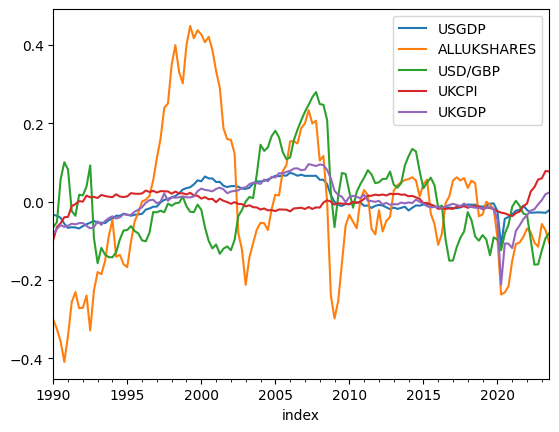

In [104]:
detrended_df.plot()

In [85]:
detrended_df

,USGDP,ALLUKSHARES,USD/GBP,UKCPI,UKGDP
index,,,,,
1990-01-01,-0.033509,-0.301205,-0.065550,-0.097633,-0.081825
1990-04-01,-0.035817,-0.325252,-0.051945,-0.064628,-0.069531
1990-07-01,-0.041082,-0.356550,0.056968,-0.054943,-0.059564
1990-10-01,-0.056159,-0.408934,0.100727,-0.039603,-0.064290
1991-01-01,-0.066780,-0.342028,0.082303,-0.038566,-0.061206
...,...,...,...,...,...
2022-07-01,-0.027581,-0.104395,-0.160617,0.037326,-0.019038
2022-10-01,-0.027178,-0.114826,-0.159827,0.056543,-0.006942
2023-01-01,-0.027560,-0.056843,-0.124550,0.059664,0.004070


In [86]:
from statsmodels.tsa.api import VAR

# For detrended_df
model_detrended = VAR(detrended_df)
selected_lags_detrended = model_detrended.select_order(maxlags=10)
print(selected_lags_detrended.summary())

# For first_diff_detrended_df
model_first_diff = VAR(firs_diff_detrended_df)
selected_lags_first_diff = model_first_diff.select_order(maxlags=10)
print(selected_lags_first_diff.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -31.54      -31.43   2.006e-14      -31.49
1       -40.82     -40.15*   1.864e-18      -40.55
2       -41.21      -39.96   1.271e-18     -40.70*
3       -41.42      -39.61   1.033e-18      -40.69
4       -41.50      -39.12   9.669e-19      -40.53
5       -41.75      -38.81   7.633e-19      -40.55
6       -41.82      -38.31  7.257e-19*      -40.40
7       -41.71      -37.64   8.315e-19      -40.06
8       -41.73      -37.09   8.575e-19      -39.84
9      -41.85*      -36.65   8.011e-19      -39.74
10      -41.79      -36.02   9.170e-19      -39.44
--------------------------------------------------
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -40.85     -40.74*   1.817e-18      -40.80
1       -41.15      -40.47   1.

In [87]:
selected_lags_first_diff

In [ ]:
# Fit VAR model with the chosen lag
lag_order_detrended = selected_lags_detrended.aic
var_model_detrended = model_detrended.fit(lag_order_detrended)

lag_order_first_diff = selected_lags_first_diff.aic
var_model_first_diff = model_first_diff.fit(lag_order_first_diff)


In [118]:
lag_order_first_diff

5

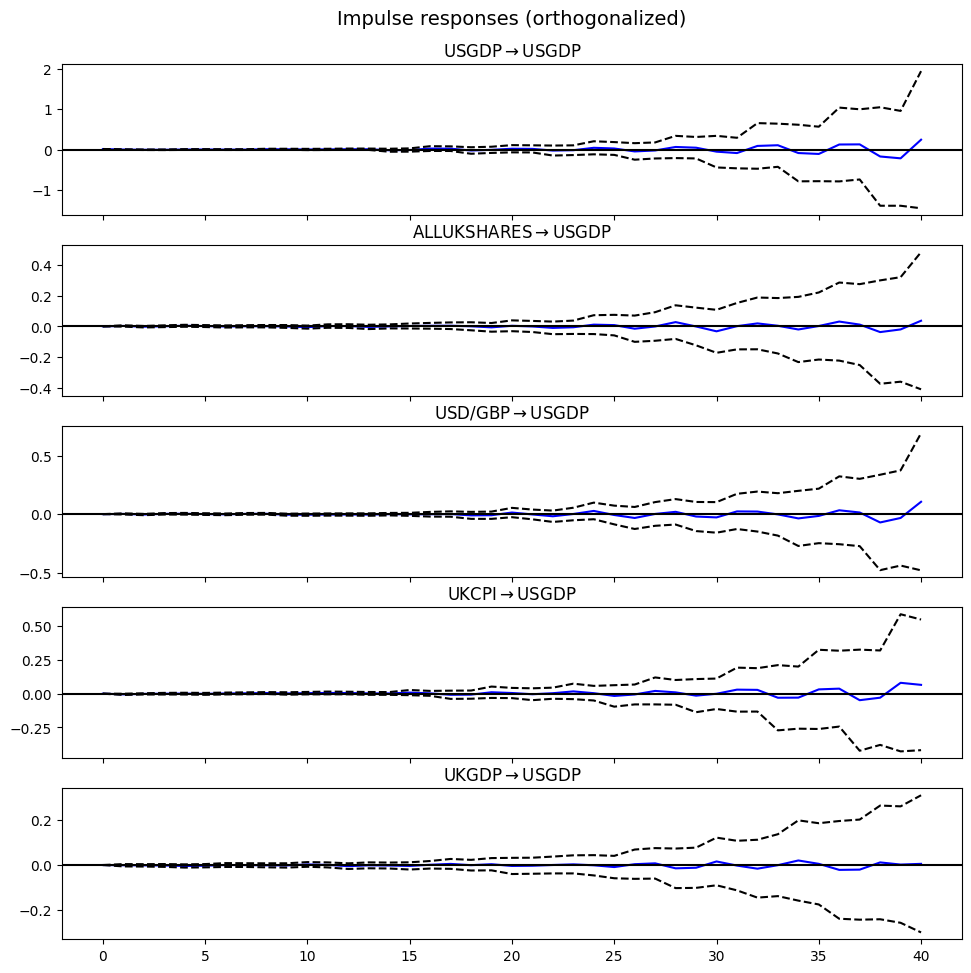

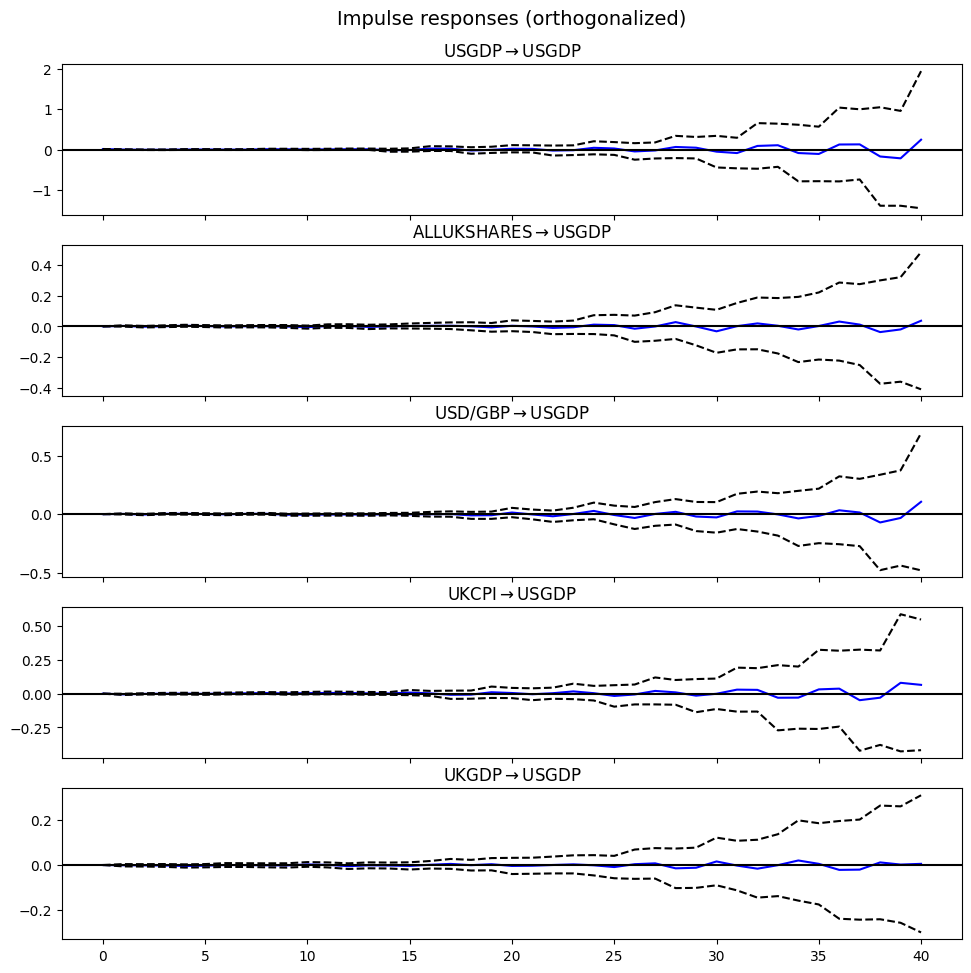

In [ ]:
# Impulse Response for detrended_df
irf_detrended = var_model_detrended.irf(40)  # 10 periods
irf_detrended.plot(orth=True, response='USGDP')  # Orthogonalized IRF

# Impulse Response for first_diff_detrended_df


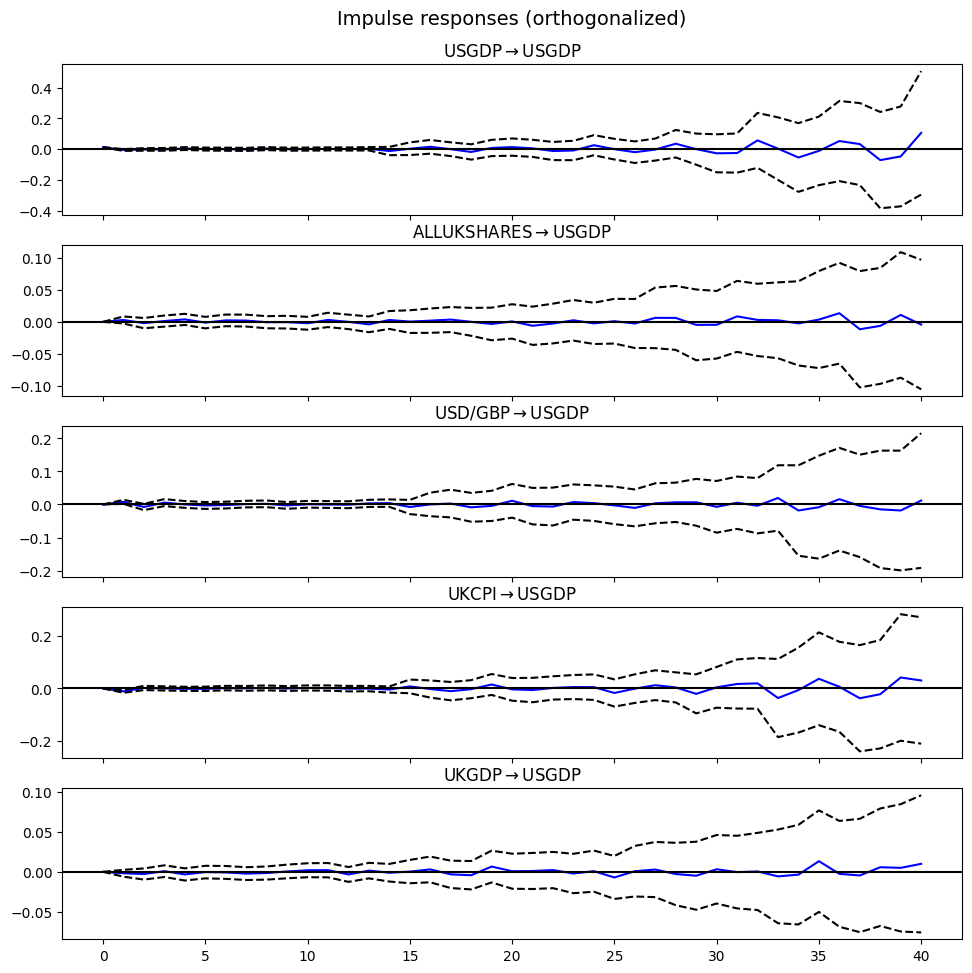

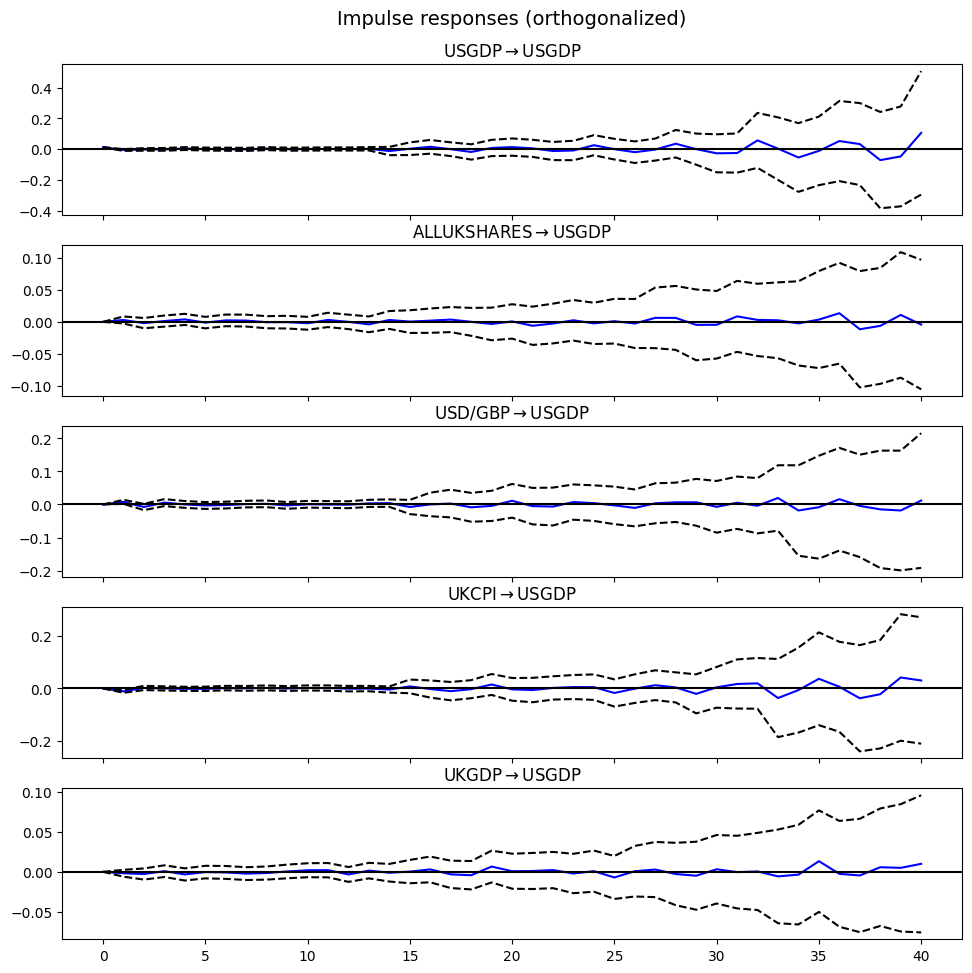

In [ ]:
irf_first_diff = var_model_first_diff.irf(40)  # 10 periods
irf_first_diff.plot(orth=True, response='USGDP')   # Orthogonalized IRF


In [120]:
from statsmodels.tsa.api import VAR

# For detrended_df
model_detrended = VAR(detrended_df)
results_detrended = model_detrended.fit(maxlags=lag_order_detrended, ic='aic')

# For first_diff_detrended_df
model_first_diff = VAR(firs_diff_detrended_df)
results_first_diff = model_first_diff.fit(maxlags=lag_order_first_diff, ic='aic')


In [145]:
# Forecasting for the next n periods
n_forecast = 10  # or however many periods you wish to forecast

# For detrended_df
forecast_detrended = results_detrended.forecast(y=detrended_df.values[-results_detrended.k_ar:], steps=n_forecast)

# For first_diff_detrended_df
forecast_first_diff = results_first_diff.forecast(y=firs_diff_detrended_df.values[-results_first_diff.k_ar:], steps=n_forecast)


In [131]:
detrended_df.index

DatetimeIndex(['1990-01-01', '1990-04-01', '1990-07-01', '1990-10-01',
               '1991-01-01', '1991-04-01', '1991-07-01', '1991-10-01',
               '1992-01-01', '1992-04-01',
               ...
               '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-01',
               '2022-04-01', '2022-07-01', '2022-10-01', '2023-01-01',
               '2023-04-01', '2023-07-01'],
              dtype='datetime64[ns]', name='index', length=135, freq=None)

In [146]:
import pandas as pd

# Create a date range for the forecasted period
forecast_index = pd.date_range(start=detrended_df.index[-1], periods=n_forecast, freq='Q')

# For detrended_df
forecast_detrended_df = pd.DataFrame(forecast_detrended, index=forecast_index, columns=detrended_df.columns)

# For first_diff_detrended_df
forecast_first_diff_df = pd.DataFrame(forecast_first_diff, index=forecast_index, columns=firs_diff_detrended_df.columns)

<Axes: xlabel='index'>

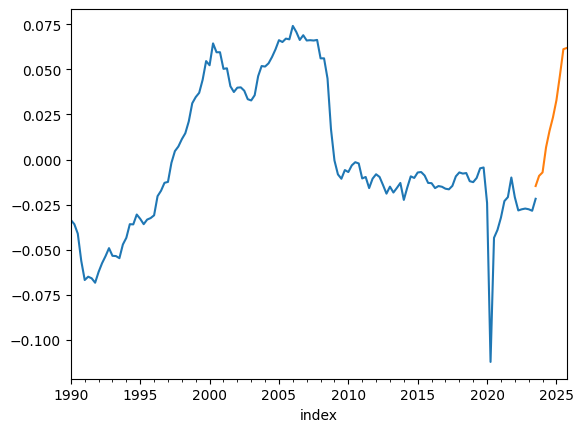

In [147]:
detrended_df.USGDP.plot()
forecast_detrended_df.USGDP.plot()

<Axes: xlabel='index'>

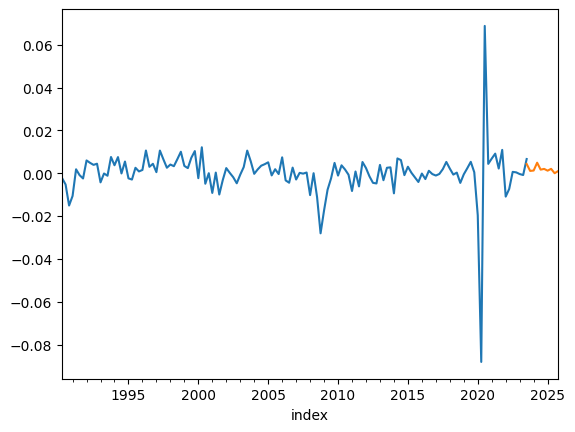

In [148]:
firs_diff_detrended_df.USGDP.plot()
forecast_first_diff_df.USGDP.plot()

In [143]:
forecast_first_diff

array([[ 0.00433245,  0.02005045,  0.01045612,  0.01058547,  0.00744696],
       [ 0.00107716, -0.00549596,  0.00903777, -0.0037872 ,  0.00108431],
       [ 0.00125662,  0.01072659,  0.00830486,  0.0099119 , -0.00349443],
       [ 0.00492057, -0.00579915,  0.01076205, -0.00611846,  0.00576724],
       [ 0.00168274,  0.02200381, -0.00635149,  0.00625106,  0.00186462]])